# Salmon Data: exploratory analysis

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
%matplotlib inline

### Load in data
Here we load in the Age, Sex and Length (ASL) data. We only keep columns that we expect to need for analysis

In [2]:
data_small = pd.read_csv('ASL_master.csv', usecols =["Species", "sampleYear", "sampleDate", "Length", "Sex", 
                "Salt.Water.Age", "Fresh.Water.Age", "DistrictID"], low_memory=False)
#output columns
data_small.columns

Index(['Species', 'sampleYear', 'sampleDate', 'Length', 'Sex',
       'Salt.Water.Age', 'Fresh.Water.Age', 'DistrictID'],
      dtype='object')

### Double check the rate of missing values
If there are a lot of missing values (read in as Nan) then that particular feature will not be reliable. It is encouraging that most data do not have any flags but we can also see that it would be unwise to rely on Weight data.

In [3]:
#find the % of entries that are nan for each column
print(data_small.shape)
data_small.isna().sum()/data_small.shape[0]

(14347461, 8)


Species            0.000000
sampleYear         0.000464
sampleDate         0.000464
Length             0.251804
Sex                0.099224
Salt.Water.Age     0.171890
Fresh.Water.Age    0.144319
DistrictID         0.010361
dtype: float64

In [4]:
#convert dates to readable format, create month column
data_small['sampleDate'] = pd.to_datetime(data_small['sampleDate'], infer_datetime_format=True)
data_small['Month'] = [data_small['sampleDate'].iloc[i].month for i in range(data_small.shape[0])]

### Plot Mean Length by Year
Here we plot the mean length of salmon by year, for each species in order to get an idea of general trends

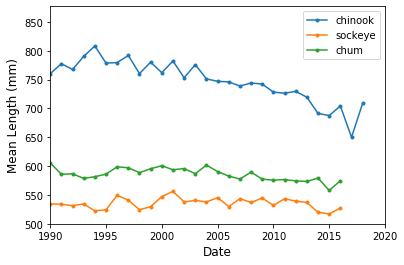

In [5]:
speciesbyyear = data_small.groupby(["sampleYear", "Species"])
meanbyyear = speciesbyyear['Length'].mean()
stdbyyear = speciesbyyear['Length'].std()
df_mean = meanbyyear.unstack()
df_std = stdbyyear.unstack()

fig, ax = plt.subplots(figsize=(6, 4))
for s in [data_small['Species'].unique()[0], data_small['Species'].unique()[-1], data_small['Species'].unique()[1]]:
    ax.errorbar(df_mean[s].index, df_mean[s].values, label = s, marker = '.')
ax.legend(fontsize = 12)
ax.set_ylabel('Mean Length (mm)', fontsize = 12)
ax.set_xlabel("Date", fontsize = 12)
ax.set_xlim(1990, 2020)
ax.legend()

### A Simple Growth Metric
As a first pass at considering the growth rates of salmon, we can compare the change in mean length with respect to the previous year. This is defined as 
$$
C = \frac{M_{y} - M_{y-1}}{M_{y-1}}
$$

with y the current year. Looking across years, we may be able to determine a trend. Perhaps high growth years preceed low growth years. 

## Growth Metric per District
The overall goal is to determine the districts with the highest growth rates and to predict growth rates for future years. As a start to this goal, this metric can be applied to specific districts. Though the direction of the change flips between years, the overall size of the change is decreasing with year

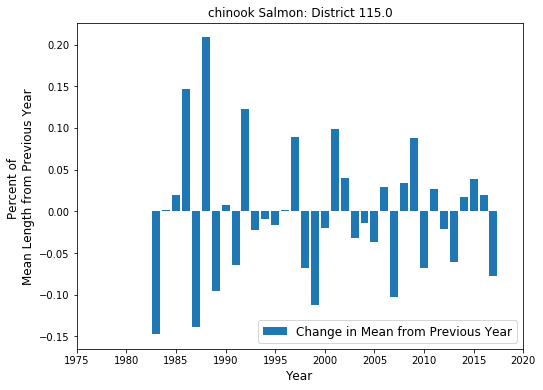

In [6]:
salmontype = 'chinook'

chinook = data_small[data_small['Species']==salmontype]
chinookyear = chinook.groupby(['sampleYear','DistrictID'])
yearcount = chinookyear['Length'].mean().unstack()
yearcount_std = chinookyear['Length'].std().unstack()

distlist = chinook['DistrictID'].unique()
d = 7
diff_mean = []
diff_std = []
for y in np.arange(1, yearcount.shape[0]):
    change_mean = (yearcount[distlist[d]].values[y] - yearcount[distlist[d]].values[y-1])/yearcount[distlist[d]].values[y-1]
    diff_mean.append(change_mean)
    change_std = (yearcount_std[distlist[d]].values[y])/yearcount[distlist[d]].values[y-1]
    diff_std.append(change_std)
    
fig, ax = plt.subplots(figsize=(8,6))
#ax.bar(yearcount.index[1:], np.array(diff_std), label = 'Std')
ax.bar(yearcount.index[1:], np.array(diff_mean), label = 'Change in Mean from Previous Year')

ax.set_xlim(1975, 2020)
ax.set_ylabel('Percent of \nMean Length from Previous Year', fontsize = 12)
ax.set_xlabel('Year', fontsize = 12)
ax.set_title('{} Salmon: District {}'.format(salmontype, distlist[d]))
ax.legend(fontsize = 12)

# Select Districts to Train on

In [7]:
salmontype = 'sockeye'
salmon = data_small[data_small['Species']==salmontype]
salmonyear = salmon.groupby(['DistrictID','sampleYear', "Month"])
yearmean = salmonyear['Length'].mean().unstack()

test = yearmean.iloc[:]
#test = test.dropna(axis='rows', thresh=3)
test = test.dropna(axis='columns', thresh=100)

print(test.shape[0]*test.shape[1])
districts_use = np.unique(np.array([i[0] for i in test.stack().index]))

11952


# Time Series Data

In [8]:
def makeTimeSeries(data, salmontype, feature, d, months):
    salmon = data[data['Species']==salmontype]
    salmonyear = salmon.groupby(['DistrictID', 'sampleYear', 'Month'])
    
    yearmean = salmonyear[feature].mean().unstack()
    #yearmean = yearmean.dropna(axis='rows', thresh=3)
    yearmean = yearmean.dropna(axis='columns', thresh=100).stack()
    
    yearstd =salmonyear[feature].std().unstack()
    #yearstd = yearstd.dropna(axis='rows', thresh=3)
    yearstd = yearstd.dropna(axis='columns', thresh=100).stack()
    
    column_names = ['year', 'month']
    for i in np.arange(0, months+1):
        name1 = 'mean'+str(i)
        name2 = 'std'+str(i)
        name3 = 'change'+str(i)
        column_names.append(name1)
        column_names.append(name2)
        column_names.append(name3)
        
    timedata = pd.DataFrame(columns = column_names)
    
    #loop through months/years for this district
    for y in np.arange(1, yearmean[d].shape[0]-months):
        yr = yearmean[d].index[y][0]
        m = yearmean[d].index[y][1]
        
        yearrow = [yr, m]
        #calculate the difference between the months
        for i in np.arange(0, months+1):
            yr_prev = yearmean[d].index[y-i-1][0]
            m_prev = yearmean[d].index[y-i-1][1]
            
            yr_now = yearmean[d].index[y-i][0]
            m_now = yearmean[d].index[y-i][1]
            
            try: 
                if i==0: #save current year
                    change_std = yearstd[(d, yr, m)]
                    change_mean = yearmean[(d, yr, m)]
                    change = 0.0
                else: #save previous years
                    change_mean = yearmean[(d, yr_now, m_now)]
                    change_std = yearstd[(d, yr_now, m_now)]
                    change = (yearmean[(d, yr_now, m_now)] - yearmean[(d,yr_prev,m_prev)])
                    #change_std = (yearstd[(d, yr_now, m_now)] - yearstd[(d,yr_prev,m_prev)])
            except KeyError:
                change_std = None
                change_mean = None
                change = None
                pass
            yearrow.append(change_mean)
            yearrow.append(change_std)
            yearrow.append(change)
            
        #save row to dataframe
        row = pd.DataFrame([yearrow], columns = column_names)
        timedata = timedata.append(row, ignore_index = True)
    
    return timedata

In [9]:
#make time series (dataset, salmontype, feature, district, years)
numyears = 3
timedata = makeTimeSeries(data_small, 'sockeye', 'Length', districts_use[0], numyears)
for i in districts_use[1:]:
    timedata_next = makeTimeSeries(data_small, 'sockeye', 'Length', i, numyears)
    timedata = pd.concat([timedata, timedata_next], ignore_index=True)

In [10]:
#consider the number of Nans 
print(timedata.shape)
timedata.isna().sum()/timedata.shape[0]

(4764, 14)


year       0.000000
month      0.000000
mean0      0.010285
std0       0.010285
change0    0.010285
mean1      0.010076
std1       0.010076
change1    0.010076
mean2      0.010285
std2       0.010285
change2    0.010285
mean3      0.010285
std3       0.010285
change3    0.010285
dtype: float64

In [11]:
#drop nans
timedata.dropna(inplace=True)
print(timedata.shape)
timedata.isna().sum()/timedata.shape[0]

(4600, 14)


year       0.0
month      0.0
mean0      0.0
std0       0.0
change0    0.0
mean1      0.0
std1       0.0
change1    0.0
mean2      0.0
std2       0.0
change2    0.0
mean3      0.0
std3       0.0
change3    0.0
dtype: float64

In [12]:
shorttime = timedata[-130:]
y_test = shorttime[['mean0']].values.reshape(-1)
X_test = shorttime[['year','month','mean1', 'std1', 'change1', 'mean2', 'std2', 'change2', 'mean3', 'std3', 'change3']]

traintime = timedata[:-130]
y_train = traintime[['mean0']].values.reshape(-1)
X_train = traintime[['year','month','mean1', 'std1', 'change1', 'mean2', 'std2', 'change2', 'mean3', 'std3', 'change3']]

# Model Testing

LR: 0.311998 (0.137712)


/Users/jneilcottle/.local/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:585: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/jneilcottle/.local/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:585: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


NN: 0.262838 (0.183507)
KNN: 0.141710 (0.146668)
RF: 0.202434 (0.163833)


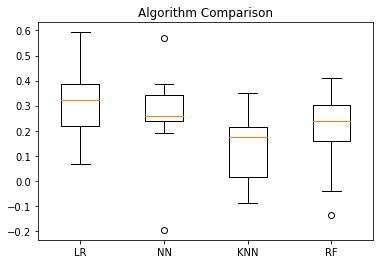

In [13]:
from sklearn.model_selection import TimeSeriesSplit
import sklearn.metrics as metrics

def regression_results(y_true, y_pred):
    # Regression metrics
    explained_variance=metrics.explained_variance_score(y_true, y_pred)
    mean_absolute_error=metrics.mean_absolute_error(y_true, y_pred) 
    mse=metrics.mean_squared_error(y_true, y_pred) 
    median_absolute_error=metrics.median_absolute_error(y_true, y_pred)
    r2=metrics.r2_score(y_true, y_pred)
    
    print('explained_variance: ', round(explained_variance,4))    
    print('r2: ', round(r2,4))
    print('MAE: ', round(mean_absolute_error,4))
    print('MSE: ', round(mse,4))
    print('RMSE: ', round(np.sqrt(mse),4))
    
from sklearn.linear_model import LinearRegression
from sklearn.neural_network import MLPRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score


models = []
models.append(('LR', LinearRegression()))
models.append(('NN', MLPRegressor(solver = 'adam')))
models.append(('KNN', KNeighborsRegressor())) 
models.append(('RF', RandomForestRegressor(n_estimators = 10))) 

# Evaluate each model in turn
results = []
names = []
for name, model in models:
    # TimeSeries Cross validation
    tscv = TimeSeriesSplit(n_splits=10)
    cv_results = cross_val_score(model, X_train, y_train, cv=tscv, scoring='r2')

    results.append(cv_results)
    names.append(name)
    print('%s: %f (%f)' % (name, cv_results.mean(), cv_results.std()))
    
# Compare Algorithms
plt.boxplot(results, labels=names)
plt.title('Algorithm Comparison')
plt.show()

In [14]:
from sklearn.metrics import make_scorer
def rmse(actual, predict):
    predict = np.array(predict)
    actual = np.array(actual)
    distance = predict - actual
    square_distance = distance ** 2
    mean_square_distance = square_distance.mean()
    score = np.sqrt(mean_square_distance)
    return score

rmse_score = make_scorer(rmse, greater_is_better = False)

from sklearn.model_selection import GridSearchCV
model = RandomForestRegressor()
param_search = { 
    'n_estimators': [20, 50, 100],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [i for i in range(5,15)]
}

tscv = TimeSeriesSplit(n_splits=10)
gsearch = GridSearchCV(estimator=model, cv=tscv, param_grid=param_search, scoring = rmse_score)
gsearch.fit(X_train, y_train)
best_score = gsearch.best_score_
best_model = gsearch.best_estimator_

In [15]:
y_true = y_test
y_pred = best_model.predict(X_test)
regression_results(y_true, y_pred)

explained_variance:  0.2401
r2:  0.1822
MAE:  12.9242
MSE:  293.6718
RMSE:  17.1369


# Visualize Predictions

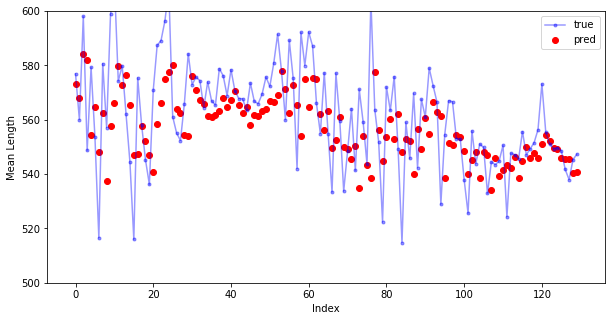

In [16]:
fig, ax = plt.subplots(1, figsize=(10, 5))
#ax.scatter(traintime.index[-130:], traintime['mean0'][-130:], label = 'train')
ax.plot(range(shorttime.shape[0]), shorttime['mean0'], label= 'true', color = 'blue', alpha = 0.4, marker = '.')
ax.scatter(range(shorttime.shape[0]), y_pred[:], label = 'pred', color = 'red')
ax.set_ylabel('Mean Length')
ax.set_xlabel('Index')
ax.set_ylim(500,600)
#ax.set_xlim(60, 120)
ax.legend()

# Test on a single district

(137, 14)
explained_variance:  0.4082
r2:  0.361
MAE:  9.3376
MSE:  143.3971
RMSE:  11.9749


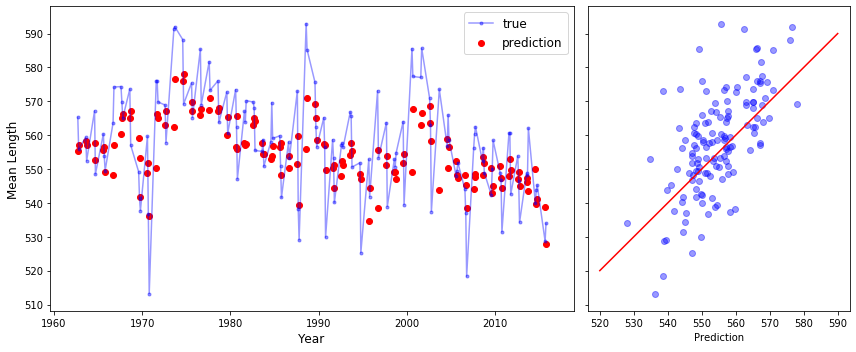

In [17]:
#make time series (dataset, salmontype, feature, district, years)
numyears = 3
timedata_test = makeTimeSeries(data_small, 'sockeye', 'Length', 326, numyears)
print(timedata_test.shape)
y_test = timedata_test[['mean0']].values.reshape(-1)
X_test = timedata_test[['year','month','mean1', 'std1', 'change1', 'mean2', 'std2', 'change2','mean3', 'std3', 'change3']]

#print results
y_pred = best_model.predict(X_test)
regression_results(y_test, y_pred)

y_axis = timedata_test['year']+timedata_test['month']/10.



#plot results
fig, ax = plt.subplots(1, 2, gridspec_kw={'width_ratios': [2, 1]}, figsize=(12, 5), sharey=True)

ax[0].plot(y_axis, timedata_test['mean0'], label= 'true', color = 'blue', alpha=0.4, marker = '.')
ax[0].scatter(y_axis, y_pred[:], label = 'prediction', color = 'red')
ax[0].set_ylabel('Mean Length', fontsize = 12)
ax[0].set_xlabel('Year', fontsize = 12)
ax[0].legend(fontsize = 12)


ax[1].scatter(y_pred, y_test, color = 'blue', alpha = 0.4)
ax[1].set_xlabel('Prediction')
x = np.array([520,590])
y = x
ax[1].plot(x, y, color = 'red')
fig.tight_layout()

# Other Tests

Text(0.5, 0, 'Year')

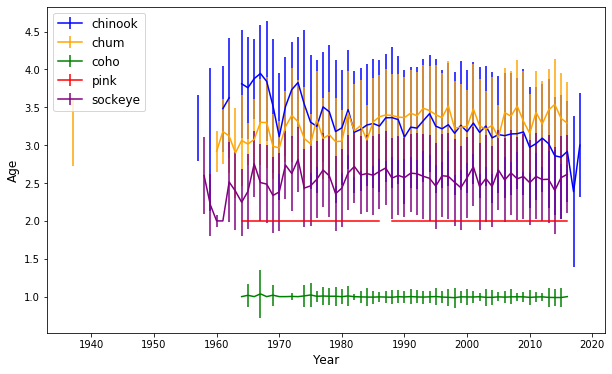

In [72]:
colors = {'chinook':'blue', 'chum':'orange', 'coho':'green', 'pink':'red', 'sockeye':'purple' }
speciesbyyear = data_small.groupby(["sampleYear", "Species"])
meanbyyear = speciesbyyear['Salt.Water.Age'].mean()
stdbyyear = speciesbyyear['Salt.Water.Age'].std()
df_mean = meanbyyear.unstack()
df_std = stdbyyear.unstack()

fig, ax = plt.subplots(figsize=(10,6))
for s in data_small['Species'].unique():
    ax.errorbar(df_mean[s].index, df_mean[s].values, label = s, color = colors[s], yerr = df_std[s].values)
    
#meanbyyear = speciesbyyear['Fresh.Water.Age'].mean()
#stdbyyear = speciesbyyear['Fresh.Water.Age'].std()
#df_mean = meanbyyear.unstack()
#df_std = stdbyyear.unstack()

#for s in data_small['Species'].unique():
#    ax.plot(df_mean[s].index, df_mean[s].values, label = s+' fresh', linestyle = 'dashed', color = colors[s])
    
    
ax.legend(fontsize = 12)
ax.set_ylabel('Age', fontsize = 12)
ax.set_xlabel("Year", fontsize = 12)

(200, 800)

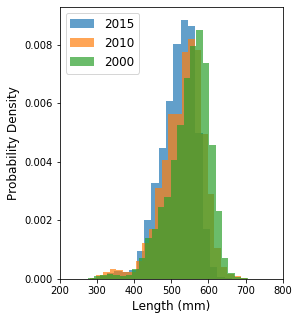

In [403]:
def extractyear(data, year):
    return data[data['sampleYear']==year]

#yeardata = extractyear(data_small, 2012)

fig, ax = plt.subplots(figsize=(4,5))
mon = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

for y in [2015, 2010, 2000]:
    yeardata = extractyear(data_small, y)
    species = yeardata[yeardata['Species']=='sockeye']
    species = species[species['Length'] < 1500]
    ax.hist(species['Length'], label = y, bins = 50, density=True, linewidth=2, alpha = 0.7)
ax.legend(loc=2, fontsize = 12)
ax.set_xlabel('Length (mm)', fontsize = 12)
ax.set_ylabel('Probability Density', fontsize = 12)
ax.set_xlim(200, 800)